# Linear Function Approximation with Optimism

In [1]:
%matplotlib inline

import pandas as pd
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import os
from tqdm import tqdm
from scipy.stats.qmc import LatinHypercube
import statsmodels.api as sm

sys.path.append("core") 

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import RidgeCV

plt.style.use('matplotlibrc')
plt.rcParams['axes.formatter.useoffset'] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tetris_env import TetrisEnv


In [5]:
#env = gym.envs.make("BipedalWalker-v3", hardcore=False)
#env = gym.envs.make("Walker2d", exclude_current_positions_from_observation=False)
env = TetrisEnv(seed=0)

plt.style.use('matplotlibrc')

d = 640
nActions = 4
H = 40
Noff = 200 #50

class LFAAgent:

    def __init__(self, seed=None, unif=False):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.

        # Initial learning rate: 0.01
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.001
        # Initial epsilon for exploration: 0.5
        # Epsilon decay for each episode: 0.98
        self.w = np.zeros((640,))  # The weight vector to be learned
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        self.unif = unif
        
    def maxQ(self, state_game, state_piece, prec=None, lam=1):
        a_candidates = np.vstack([[a_pos, a_rot] 
                              for a_pos in range(5) for a_rot in range(4)])
        phix = np.vstack([self.phi(state_game, state_piece, a_pos, a_rot) 
                for a_pos in range(5) for a_rot in range(4)])
        # search over actions
        scores = phix @ self.w
        if prec is not None:
            scores += lam*np.sqrt(np.diag(phix @ prec @ phix.T))
        return scores

    def select_action(self, state_game, state_piece, prec=None, lam=1):
        """
        This function returns an action for the agent to take.
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
        Returns:
            action_pos: a_{pos}, the position where the agent will put the next piece down
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down
        """
        
        # Please complete codes for choosing an action given the current state  
        """
        Hint: You may use epsilon-greedy for exploration. 
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi). 
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        if self.unif:
            action_pos = self.rng.choice(5)
            action_rot = self.rng.choice(4)
        else:
            actions = np.argmax(self.maxQ(state_game, state_piece, prec=prec, lam=lam))
            #actions = np.argmax(np.array([self.w.T @ self.phi(state_game, state_piece, a_pos, a_rot) 
            #              for a_pos in range(5) for a_rot in range(4)]))
            action_pos = int(actions/4)
            action_rot = actions % 4
        ### END SOLUTION
        return action_pos, action_rot
    
    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        Args:
            - p: the piece
            - action_rot: clockwise rotation of the piece. 
                          action_rot = 0, 1, 2, or 3.
                          0 means no rotation.
        Returns:
            - a new piece after the rotation
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + (
                1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot = action_rot - 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p
    
    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a)
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
        Returns:
            feature_vec: feature vector
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec

        return feature_vec


In [6]:
def collect_traj(env, agent, H):
    state_game, state_piece = env.reset()
    rewards = []
    phiX = []
    states = []
    actions = []
    nextstates = []
    for step in range(H):
        states.append(np.array([state_game, state_piece]))
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        state_game, state_piece, reward = env.step(action_pos, action_rot)
        phix = agent.phi(state_game, state_piece, action_pos, action_rot)
        actions.append(np.array([action_pos, action_rot]))
        phiX.append(phix)
        rewards.append(reward)
        nextstates.append(np.array([state_game, state_piece]))
    return np.vstack(phiX), np.vstack(states), np.vstack(actions), np.array(rewards), np.vstack(nextstates)

def collect_dataset(env, agent, N, H):
    phiX = []
    rewards = []
    states = []
    actions = []
    nextstates = []
    for n in range(N):
        phi_traj, s_traj, a_traj, r_traj, sp_traj = collect_traj(env, agent, H)
        phiX.append(phi_traj[None,...])
        states.append(s_traj[None,...])
        actions.append(a_traj[None,...])
        nextstates.append(sp_traj[None,...])
        rewards.append(r_traj)
    return np.concatenate(phiX, axis=0), np.concatenate(states, axis=0),\
                np.concatenate(actions, axis=0), np.vstack(rewards), \
                np.concatenate(nextstates, axis=0)

phiX, states, actions, rewards, nextstates = collect_dataset(env, LFAAgent(unif=True), Noff, H)


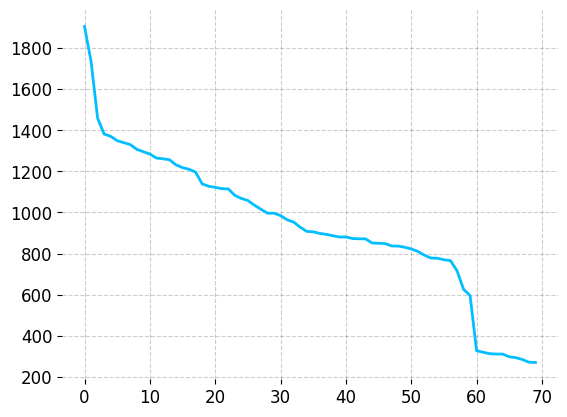

In [46]:
k = 60
Vts = np.linalg.svd(np.vstack(phiX), full_matrices=True)[2]
projOff = Vts[:k, :].T @ Vts[:k, :]
projOn = np.eye(d) - projOff
plt.plot(np.linalg.eigh(np.vstack(phiX).T @ np.vstack(phiX))[0].T[::-1][:k+10])
plt.show()

In [ ]:
# k = 40
# Vts = np.linalg.svd(phiX.transpose(1,0,2), full_matrices=True)[2]
# # projection to offline partition is k x d. 
# # Offline partition is subspace spanned by top k singular vectors
# # of the offline dataset
# # USV^T, projection is VkVk^T
# projOff = Vts[:,:k,:].transpose(0,2,1) @ Vts[:,:k,:]
# #projOn = Vts[:,k:,:] #
# # I - VkVk^T
# projOn = np.eye(d) - projOff
# plt.plot(np.linalg.eigh(phiX.transpose(0,2,1)@ phiX)[0].T[::-1][:k+10])
# plt.show()

In [70]:
def lsvi(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, T, stationary=False):
    d = phiX.shape[-1]
    w = np.random.uniform(-1,-1,size=d)
    errs = np.zeros((T, H))
    errs_off = np.zeros((T, H))
    errs_on = np.zeros((T, H))
    ws = np.zeros((T, H, d))
    n = phiX.shape[0]
    agent = LFAAgent()
    
    
    for t in tqdm(range(T)):
        # rollout under policy induced by w
        phi_traj, s_traj, a_traj, r_traj, sp_traj = \
                        collect_traj(env, agent, H)
        
        phiX = np.concatenate([phiX, phi_traj[None,...]], axis=0)
        rewards = np.concatenate([rewards, r_traj[None,...]], axis=0)
        actions = np.concatenate([actions, a_traj[None,...]], axis=0)
        states = np.concatenate([states, s_traj[None,...]], axis=0)
        nextstates = np.concatenate([nextstates, sp_traj[None,...]], axis=0)
        
        # bellman backups, save bellman errors
        for h in reversed(range(H)):
            oldw = w
            prec = np.linalg.inv(phiX[:,h,:].T @ phiX[:,h,:] + 0.01*np.eye(d))
            if h == H-1:
                Qp = np.zeros(rewards[:,0].shape)
            else:
                
                Qp = np.array([np.max(agent.maxQ(sp[0], sp[1],
                                                 prec=prec, lam=1))
                                             for sp in nextstates[:,h,:]]) #prec=prec
                
            w = prec @ phiX[:,h,:].T @ (rewards[:,h]+Qp)
            # flatten N, H if MDP close to stationary
            if stationary:
                if h != 0:
                    err = 0
                    err_off = 0
                    err_on = 0
                else:
                    phix = np.vstack(phiX[n:])
                    projXoff = (projOff@phix[...,None]).squeeze(-1)
                    projXon = (projOn@phix[...,None]).squeeze(-1)
                    err = np.linalg.eigh(phix.T @ phix)[0][0]
                    # 1/k-th largest, i.e. d-kth smallest eigenvalue
                    err_off = np.linalg.eigh(projXoff.T @ projXoff)[0][d-k]
                    # 1/(d-k)-th largest, i.e. kth-smallest eigenvalue
                    err_on = np.linalg.eigh(projXon.T @ projXon)[0][k]
                    
            else:
                projXoff = (projOff[None,...] @ phiX[n:,:,:,None]).squeeze(-1)
                projXon = (projOn[None,...] @ phiX[n:,:,:,None]).squeeze(-1)
                err = np.linalg.eigh(phiX[n:,h,:].T @ phiX[n:,h,:])[0][0]
                # 1/k-th largest, i.e. d-kth smallest eigenvalue
                err_off = np.linalg.eigh(projXoff[:,h,:].T @ projXoff[:,h,:])[0][d-k]
                # 1/(d-k)-th largest, i.e. kth-smallest eigenvalue
                err_on = np.linalg.eigh(projXon[:,h,:].T @ projXon[:,h,:])[0][k]
                
            # plt.plot(np.abs(np.linalg.eigh(phiX[n:,h,:].T @ phiX[n:,h,:])[0]), label='overall')
            # plt.plot(np.abs(np.linalg.eigh(projXoff[:,h,:].T @ projXoff[:,h,:])[0]), label='off')
            # plt.plot(np.abs(np.linalg.eigh(projXon[:,h,:].T @ projXon[:,h,:])[0]), label='on')
            # plt.yscale('symlog')
            # plt.legend()
            # return
            agent.w = w
            ws[t,h] = w
            errs[t,h] = err
            errs_off[t,h] = err_off
            errs_on[t,h] = err_on
            #print('overall', err, 'min', min(err_off, err_on), 'off:', err_off, 'on:', err_on)
            
    return ws, errs, errs_off, errs_on, phiX, states, actions, rewards, nextstates


n_trials = 1
errs_hy_trials = []
errs_hy_off_trials = []
errs_hy_on_trials = []
errs_on_trials = []
errs_on_off_trials = []
errs_on_on_trials = []
for t in range(n_trials):
    ws_hy, errs_hy, errs_off_hy, errs_on_hy, phiX_hy, states_hy, actions_hy, rewards_hy, nextstates_hy = \
            lsvi(env, phiX, projOff, projOn, 
                 states, actions, rewards, nextstates, H, 200, stationary=True)
    ws_on, errs_on, errs_off_on, errs_on_on, phiX_on, states_on, actions_on, rewards_on, nextstates_on = \
            lsvi(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 200, stationary=True)
    errs_hy_trials.append(errs_hy)
    errs_hy_off_trials.append(errs_off_hy)
    errs_hy_on_trials.append(errs_on_hy)
    errs_on_trials.append(errs_on)
    errs_on_off_trials.append(errs_off_on)
    errs_on_on_trials.append(errs_on_on)

 18%|█▊        | 35/200 [03:33<16:48,  6.11s/it]


KeyboardInterrupt: 

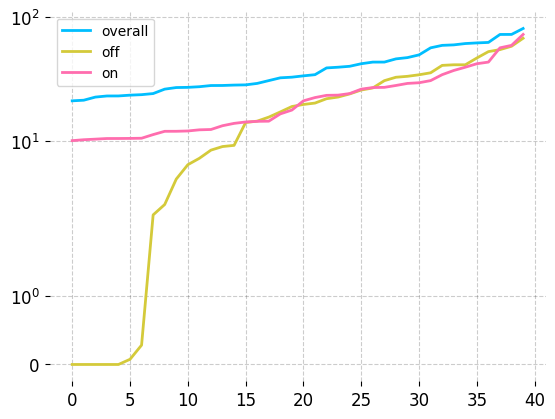

In [29]:
h=5
k_thresh = 600
projXoff = (projOff[None,...] @ phiX_hy[Noff:,:,:,None]).squeeze(-1)
projXon = (projOn[None,...] @ phiX_hy[Noff:,:,:,None]).squeeze(-1)
plt.plot(np.abs(np.linalg.eigh(phiX_hy[Noff:,h,:].T @ phiX_hy[Noff:,h,:])[0])[k_thresh:], label='overall')
plt.plot(np.abs(np.linalg.eigh(projXoff[:,h,:].T @ projXoff[:,h,:])[0])[k_thresh:], label='off')
plt.plot(np.abs(np.linalg.eigh(projXon[:,h,:].T @ projXon[:,h,:])[0])[k_thresh:], label='on')
plt.yscale('symlog') 
plt.legend()

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_1546034/901540768.py:8: RuntimeWarning: divide by zero encountered in true_divide
  hy_arr = 1/np.min(np.abs(errs_parts_hy[i]),-1)
/tmp/ipykernel_1546034/901540768.py:9: RuntimeWarning: divide by zero encountered in true_divide
  on_arr = 1/np.min(np.abs(errs_parts_on[i]),-1)
/home/kevin/anaconda3/envs/clap/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 3/3 [00:00<00:00, 60.16it/s]


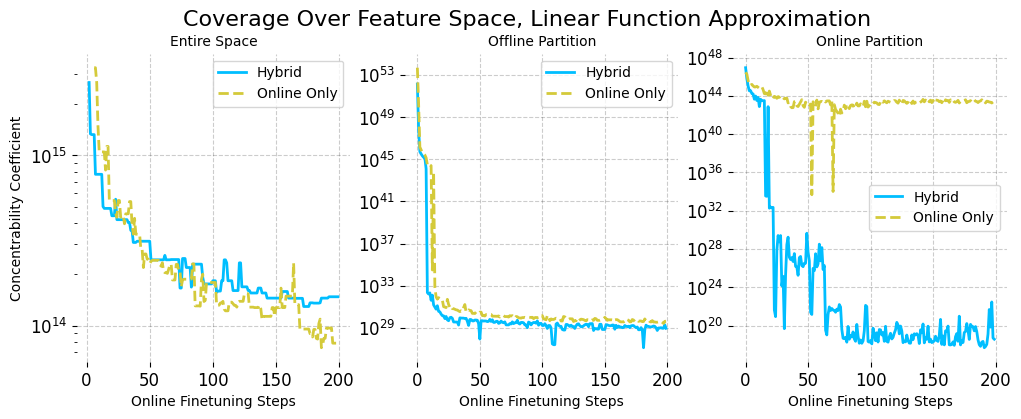

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [np.array(errs_hy_trials), np.array(errs_hy_off_trials), np.array(errs_hy_on_trials)]
errs_parts_on = [np.array(errs_on_trials), np.array(errs_on_off_trials), np.array(errs_on_on_trials)]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in tqdm(range(3)):
    hy_arr = 1/np.min(np.abs(errs_parts_hy[i]),-1)
    on_arr = 1/np.min(np.abs(errs_parts_on[i]),-1)
    ax[i].plot(hy_arr.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(on_arr.mean(0), linestyle='dashed',
         label='Online Only')
    N = errs_parts_hy[0].shape[1]
    ax[i].fill_between(np.arange(N),
                       hy_arr.mean(0) - 1.96*hy_arr.std(0),
                       hy_arr.mean(0) + 1.96*hy_arr.std(0),
                       alpha=0.3)
    ax[i].fill_between(np.arange(N),
                       on_arr.mean(0) - 1.96*on_arr.std(0),
                       on_arr.mean(0) + 1.96*on_arr.std(0),
                       alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
plt.savefig('figs/cov_linear.png', dpi=300)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_920046/1625118871.py:8: RuntimeWarning: divide by zero encountered in true_divide
  hy_arr = 1/np.min(np.abs(errs_parts_hy[i]),-1)
/tmp/ipykernel_920046/1625118871.py:9: RuntimeWarning: divide by zero encountered in true_divide
  on_arr = 1/np.min(np.abs(errs_parts_on[i]),-1)
/home/kevin/anaconda3/envs/clap/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_920046/1625118871.py:8: RuntimeWarning: divide by zero encountered in true_divide
  hy_arr = 1/np.min(np.abs(errs_parts_hy[i]),-1)
/tmp/ipykernel_920046/1625118871.py:9: RuntimeWarning: divide by zero encountered in true_divide
  on_arr = 1/np.min(np.abs(errs_parts_on[i]),-1)
/home/kevin/anaconda3/envs/clap/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_920046/162511887

Text(0.5, 0.99, 'Coverage Over Feature Space, Linear Function Approximation')

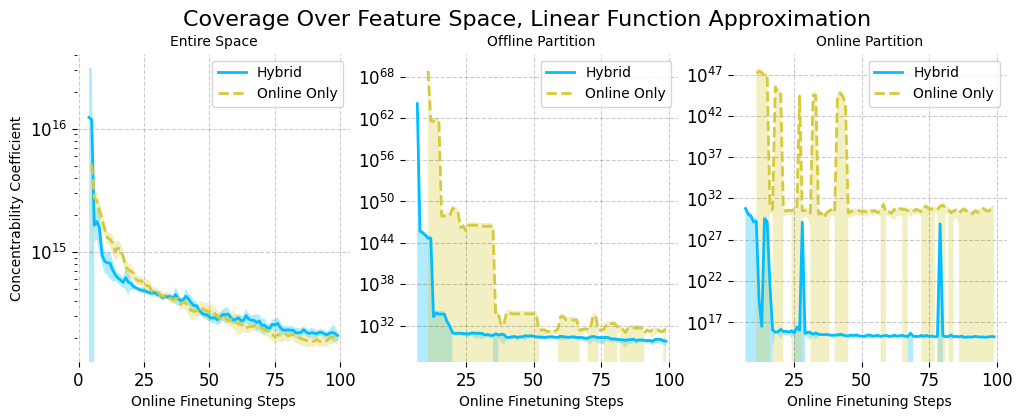

In [142]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [np.array(errs_hy_trials), np.array(errs_hy_off_trials), np.array(errs_hy_on_trials)]
errs_parts_on = [np.array(errs_on_trials), np.array(errs_on_off_trials), np.array(errs_on_on_trials)]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in tqdm(range(3)):
    hy_arr = 1/np.min(np.abs(errs_parts_hy[i]),-1)
    on_arr = 1/np.min(np.abs(errs_parts_on[i]),-1)
    ax[i].plot(hy_arr.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(on_arr.mean(0), linestyle='dashed',
         label='Online Only')
    ax[i].fill_between(np.arange(N),
                       hy_arr.mean(0) - 1.96*hy_arr.std(0)/np.sqrt(n_trials),
                       hy_arr.mean(0) + 1.96*hy_arr.std(0)/np.sqrt(n_trials),
                       alpha=0.3)
    ax[i].fill_between(np.arange(N),
                       on_arr.mean(0) - 1.96*on_arr.std(0)/np.sqrt(n_trials),
                       on_arr.mean(0) + 1.96*on_arr.std(0)/np.sqrt(n_trials),
                       alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

Text(0.5, 0.99, 'Coverage Over Feature Space, Linear Function Approximation')

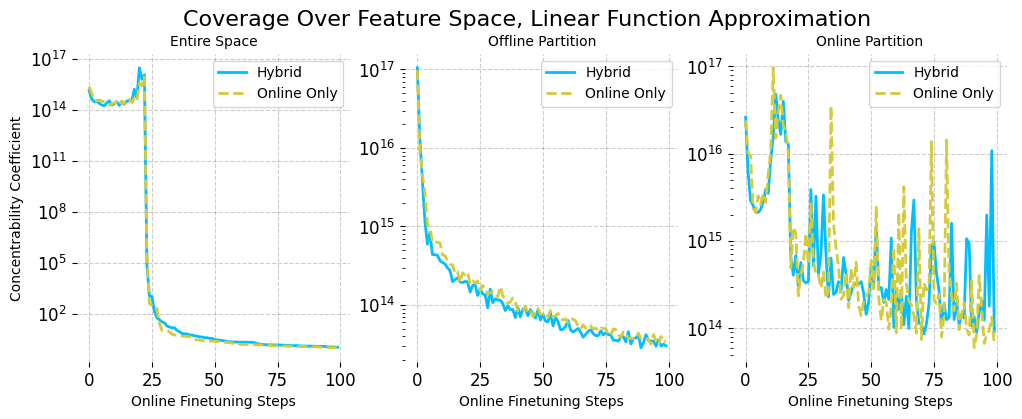

In [24]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [errs_hy, errs_off_hy, errs_on_hy]
errs_parts_on = [errs_on, errs_off_on, errs_on_on]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in range(3):
    ax[i].plot(np.max(np.abs(errs_parts_hy[i]),1), linestyle='solid',
         label='Hybrid')
    ax[i].plot(np.max(np.abs(errs_parts_on[i]),1), linestyle='dashed',
         label='Online Only')
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [errs_hy, errs_off_hy, errs_on_hy]
errs_parts_on = [errs_on, errs_off_on, errs_on_on]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in range(3):
    ax[i].plot(np.median(np.abs(errs_parts_hy[i]),1), linestyle='solid',
         label='Hybrid')
    ax[i].plot(np.median(np.abs(errs_parts_on[i]),1), linestyle='dashed',
         label='Online Only')
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

In [ ]:
# #ws_on, errs_on, errs_off_on, errs_on_on, phiX_on, states_on, actions_on, rewards_on, nextstates_on = \
# #        lsvi(env, phiX[:1], states[:1], actions[:1], rewards[:1], nextstates[:1], H, 1000, featurizer,
# #            sgd=True)

# #plt.plot(pd.Series(rewards_hy[1000:].mean(1)).rolling(100).mean())
# #plt.plot(pd.Series(rewards_on.sum(1)).rolling(10).mean())



# try:
#     err = np.inf
#     err_off = np.inf
#     err_on = np.inf
#     # kth eigenvalue of PAP^{-1} is first one in subspace
#     err_off = np.linalg.svd(
#                     np.linalg.inv(
#                         projOff[h] @ phiX[n:,h,:].T @ phiX[n:,h,:] @ projOff[h].T))[1][k]
#     err_on = np.linalg.svd(
#                     np.linalg.inv(
#                         projOn[h] @ phiX[n:,h,:].T @ phiX[n:,h,:] @ projOn[h].T))[1][d-k]
